In [1]:
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
from numpy.random import poisson as poi
import time
import genSIRUniverse as gsu
from mpl_toolkits.axes_grid1 import make_axes_locatable, ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

from numpy import poly1d, polyfit
import pandas as pd
import time
import seaborn as sns; sns.set(style="ticks", color_codes=True)

from sklearn.decomposition import NMF, PCA, FastICA
from sklearn.manifold import LocallyLinearEmbedding, TSNE, Isomap, SpectralEmbedding, MDS
from pydiffmap import diffusion_map as dm

%matplotlib inline
%load_ext autoreload
%autoreload 2

#Some global definitions
state_loc = {"S":0, "I":1, "R":2}

# Now let's try a ring-topology but with some random rewiring.

## We first try inferring from a single epidemic.

**Questions.** 
- What can we learn about the random rewiring?

In [5]:
universe_sh=(8,8)
deg_vec = [1]
rand_p0 = 0.01
conn = gsu.gen_ring_connection(*universe_sh, deg_vec=deg_vec, p0=rand_p0)
conn_ref = gsu.gen_ring_connection(*universe_sh, deg_vec=deg_vec)
su2 = gsu.sir_universe(universe_sh=universe_sh, conn=conn, alpha=0.01, beta=0.8, gamma=0.2, avg_pop_per_node=10000)
su2.initialize()
su2.iterate(1000, verbose=True)

1000 iterations took 0.409s


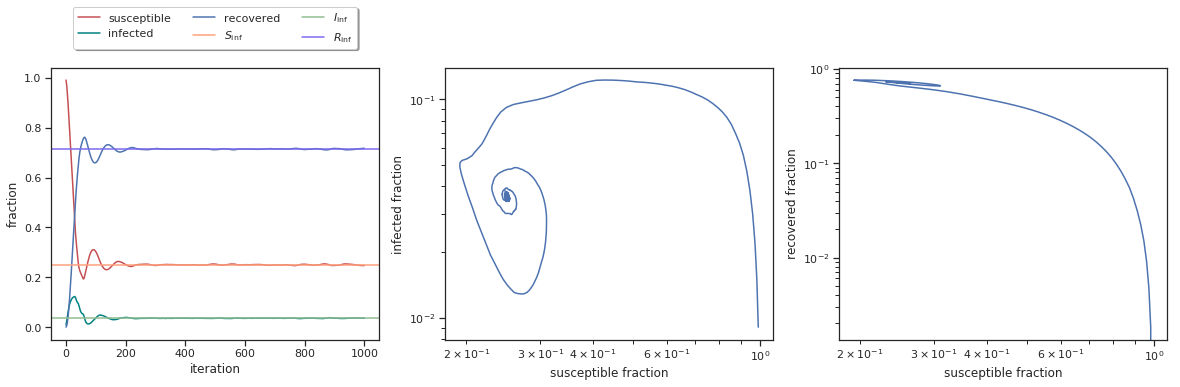

In [6]:
su2.show_state_vs_time()

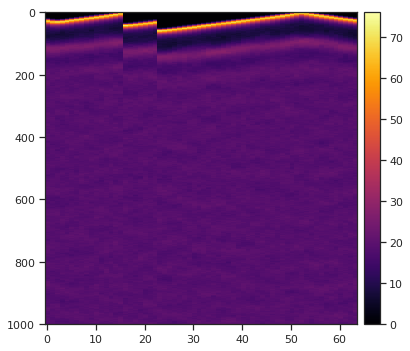

In [7]:
gsu.my_single_imshow(su2.np_state[:, su2.state_dict["I"],:]**0.5)

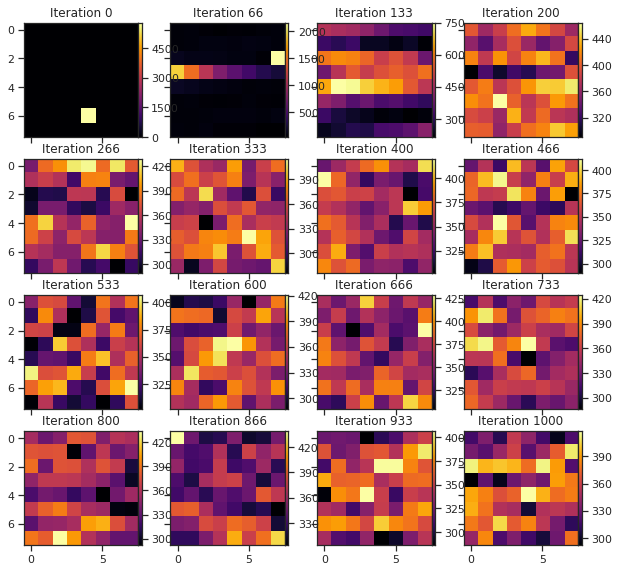

In [9]:
su2.show_snapshots(nrows_ncols=(4,4), figsize=(10,10))

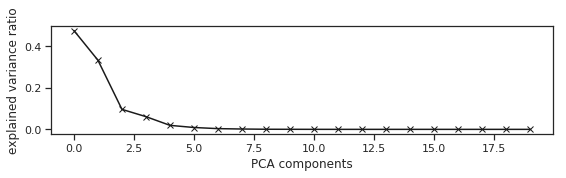

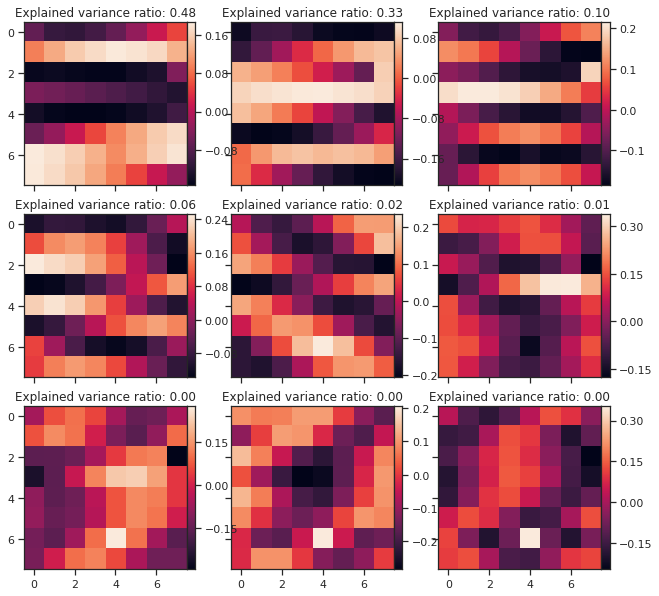

In [10]:
input_arr2 = su2.np_state[:,state_loc["I"]].T
time_of_first_infection = [ii.argmax() for ii in su2.np_state[:,state_loc["I"]].T]
pair_dot2 = np.cov(input_arr2)
pca_model2, pca_transformed_input2 = gsu.pca_and_view(pair_dot2, num_components=20, plot=False)

gsu.view_pca_2(pca_model2, universe_sh, show_shape=(3,3), punit=3.5)

/scratch/loh/apps/anaconda3/envs/idp1/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


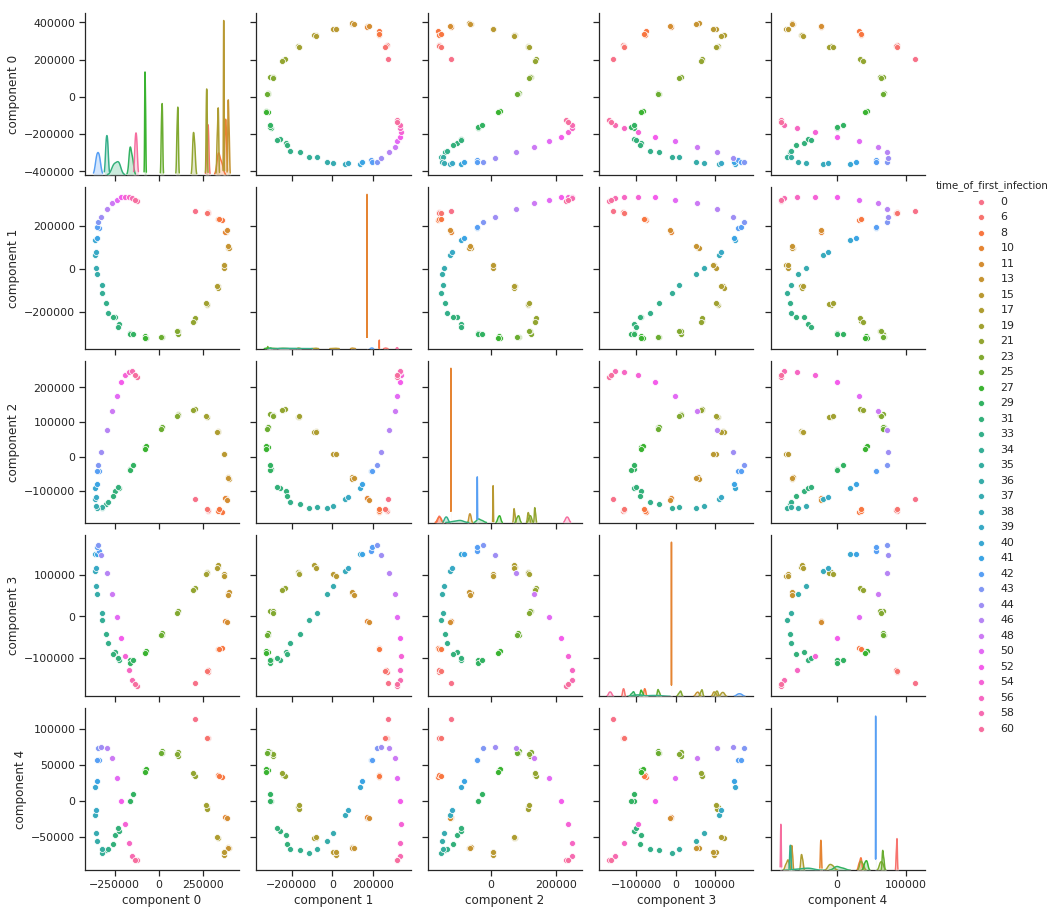

In [11]:
num_comp_to_show = 5
df = pd.DataFrame(pca_transformed_input2)
df.columns = ["component {:d}".format(i) for i in range(len(pca_transformed_input2.T))]
df['time_of_first_infection'] = time_of_first_infection
g = sns.pairplot(df, vars=["component {:d}".format(d) for d in range(num_comp_to_show)], 
                 hue='time_of_first_infection')

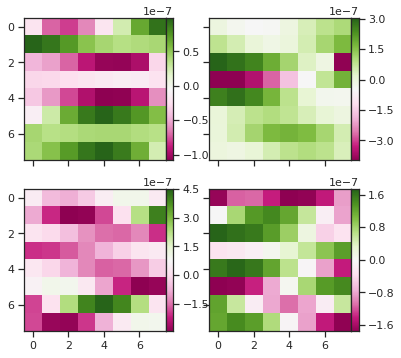

In [16]:
ica_transformer = FastICA(n_components=5, random_state=0)
ica_transformed_input = ica_transformer.fit_transform(pair_dot2)
gsu.view_components(ica_transformer, universe_sh, show_shape=(2,2), punit=3)

/scratch/loh/apps/anaconda3/envs/idp1/lib/python3.6/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


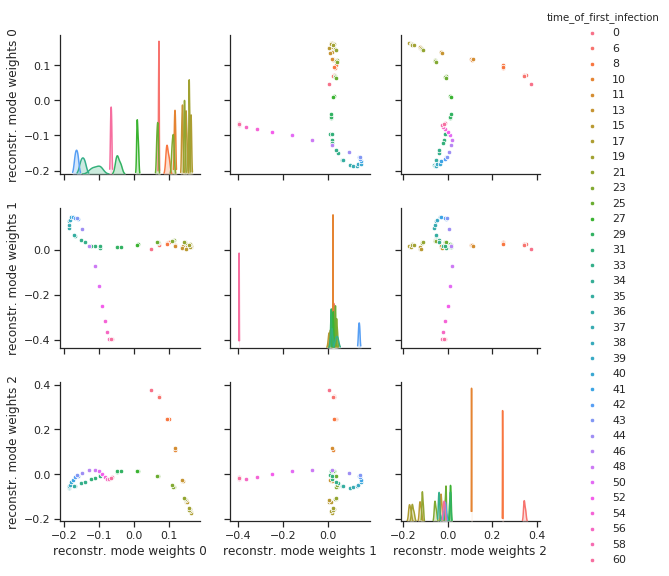

In [18]:
num_comp_to_show = 3
df = pd.DataFrame(ica_transformed_input)
df.columns = ["reconstr. mode weights {:d}".format(i) for i in range(len(ica_transformed_input.T))]
df['time_of_first_infection'] = time_of_first_infection
g = sns.pairplot(df, vars=["reconstr. mode weights {:d}".format(d) for d in range(num_comp_to_show)],
                 plot_kws={"s":20}, hue='time_of_first_infection')

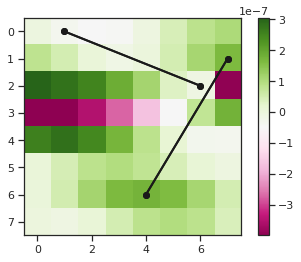

In [20]:
def loc_to_rc(v, sh):
    c = v%sh[1]
    r = v//sh[1]
    return (r,c)

component_to_plot = 1

conn_to_plot = conn-conn_ref
n0_lst, n1_lst = np.where(conn_to_plot>0)
plt.imshow(ica_transformer.components_[component_to_plot].reshape(*universe_sh), cmap='PiYG')
for e0,e1 in zip(n0_lst, n1_lst):
    rc0 = loc_to_rc(e0, universe_sh)
    rc1 = loc_to_rc(e1, universe_sh)
    vers0 = [rc0[0], rc1[0]], [rc0[1], rc1[1]]
    vers1 = [rc0[1], rc1[1]], [rc0[0], rc1[0]]
    plt.plot(*vers1, 'k-o', lw=2)
plt.colorbar()